# Base Model Results Visualization

This notebook helps you explore and visualize the evaluation results for the **base model**.

It expects the following files to be present in the current working directory:
- `metrics_base_model.json`
- `test_outputs_base_model.json`
- `test_results_base_model.jsonl` (optional, if you want to inspect per-example records)

If they are stored elsewhere, just update the file paths in the cells below.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ----- Configurable bits -----
# Name of this run / model variant
run_name = "cft_general"   # e.g. "base_model", "cft_model", "llama8b_run1", etc.

# Where all results live (adjust to your project structure)
parent = Path.cwd().parent          # or Path("/h/439/alicechua") etc.
results_root = parent / "results"   # top-level results folder

# ----- Derived paths (auto) -----
run_dir = results_root / run_name

metrics_path = run_dir / f"metrics_{run_name}.json"
outputs_path = run_dir / f"test_outputs_{run_name}.json"
results_path = run_dir / f"test_results_{run_name}.jsonl"

print("metrics_path :", metrics_path)
print("outputs_path :", outputs_path)
print("results_path :", results_path)

print("metrics exists? ", metrics_path.exists())
print("outputs exists? ", outputs_path.exists())
print("jsonl exists?   ", results_path.exists())


metrics_path : /Users/alice/Desktop/UofT/Courses/CSC2541 - Introduction to Causality/BackdoorBench/results/cft_general/metrics_cft_general.json
outputs_path : /Users/alice/Desktop/UofT/Courses/CSC2541 - Introduction to Causality/BackdoorBench/results/cft_general/test_outputs_cft_general.json
results_path : /Users/alice/Desktop/UofT/Courses/CSC2541 - Introduction to Causality/BackdoorBench/results/cft_general/test_results_cft_general.jsonl
metrics exists?  True
outputs exists?  True
jsonl exists?    True


## 1. Load metrics

In [2]:
# Load metrics summary
with metrics_path.open('r') as f:
    metrics = json.load(f)

metrics

{'total_examples': 2000,
 'no_prediction': 1414,
 'accuracy': 0.2655,
 'class_0': {'precision': 0.263681592039801,
  'recall': 0.2665995975855131,
  'f1': 0.2651325662831416,
  'support': 994},
 'class_1': {'precision': 0.26733668341708544,
  'recall': 0.2644135188866799,
  'f1': 0.2658670664667666,
  'support': 1006},
 'confusion_matrix': {'TP': 266, 'TN': 265, 'FP': 729, 'FN': 740}}

### Derived summary statistics

In [3]:
total = metrics.get('total_examples', None)
no_pred = metrics.get('no_prediction', None)
acc = metrics.get('accuracy', None)

if total is not None and no_pred is not None:
    no_pred_rate = no_pred / total
    valid_rate = 1 - no_pred_rate
else:
    no_pred_rate = None
    valid_rate = None

summary = {
    'total_examples': total,
    'no_prediction': no_pred,
    'no_prediction_rate': no_pred_rate,
    'valid_prediction_rate': valid_rate,
    'accuracy_on_all_examples': acc,
}
summary

{'total_examples': 2000,
 'no_prediction': 1414,
 'no_prediction_rate': 0.707,
 'valid_prediction_rate': 0.29300000000000004,
 'accuracy_on_all_examples': 0.2655}

## 2. Class-wise metrics table

In [4]:
# Overall accuracy
accuracy = metrics.get("accuracy")

# Per-class metrics
class_0 = metrics.get("class_0", {})
class_1 = metrics.get("class_1", {})

print("Accuracy:", accuracy)
print("\nClass 0:")
print("  Precision:", class_0.get("precision"))
print("  Recall:   ", class_0.get("recall"))
print("  F1:       ", class_0.get("f1"))
print("\nClass 1:")
print("  Precision:", class_1.get("precision"))
print("  Recall:   ", class_1.get("recall"))
print("  F1:       ", class_1.get("f1"))


Accuracy: 0.2655

Class 0:
  Precision: 0.263681592039801
  Recall:    0.2665995975855131
  F1:        0.2651325662831416

Class 1:
  Precision: 0.26733668341708544
  Recall:    0.2644135188866799
  F1:        0.2658670664667666


In [20]:
class_rows = []
for cls_name in ['class_0', 'class_1']:
    cls = metrics.get(cls_name, {})
    if cls:
        row = {
            'class': cls_name,
            'precision': cls.get('precision'),
            'recall': cls.get('recall'),
            'f1': cls.get('f1'),
            'support': cls.get('support'),
        }
        class_rows.append(row)

df_classes = pd.DataFrame(class_rows)
df_classes

,class,precision,recall,f1,support
0,class_0,0.001031,0.001006,0.001018,994
1,class_1,0.035922,0.036779,0.036346,1006


### Bar plots: precision / recall / F1 per class

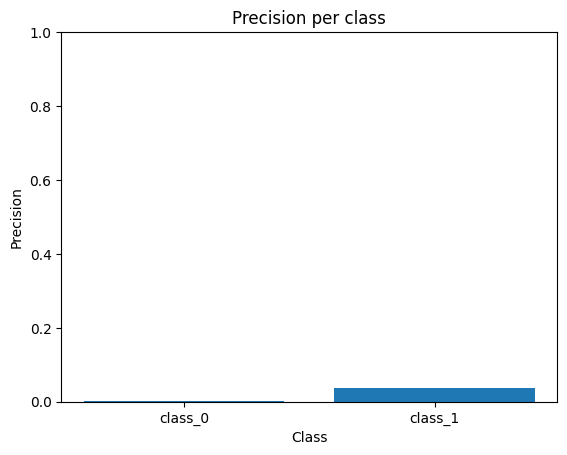

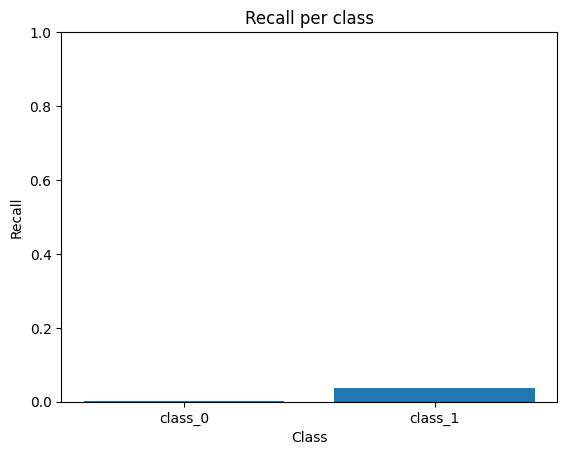

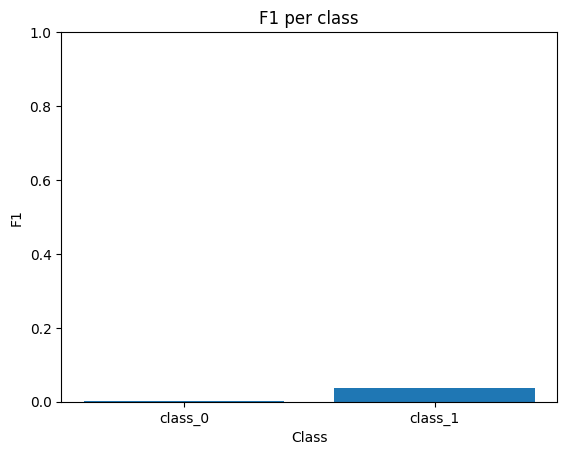

In [21]:
if not df_classes.empty:
    metrics_to_plot = ['precision', 'recall', 'f1']
    for m in metrics_to_plot:
        plt.figure()
        plt.bar(df_classes['class'], df_classes[m])
        plt.title(f'{m.capitalize()} per class')
        plt.xlabel('Class')
        plt.ylabel(m.capitalize())
        plt.ylim(0, 1)
        plt.show()

## 3. Confusion matrix

In [22]:
cm = metrics.get('confusion_matrix', {})
TP = cm.get('TP', 0)
TN = cm.get('TN', 0)
FP = cm.get('FP', 0)
FN = cm.get('FN', 0)

cm_matrix = [[TN, FP], [FN, TP]]  # rows: true 0/1, cols: pred 0/1
cm_df = pd.DataFrame(cm_matrix, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])
cm_df

,Pred 0,Pred 1
True 0,1,993
True 1,969,37


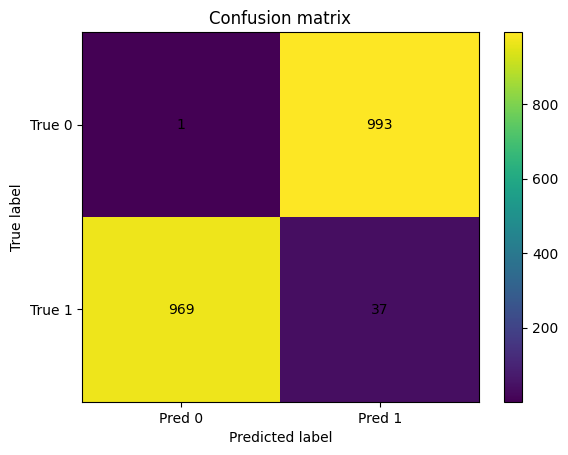

In [23]:
plt.figure()
plt.imshow(cm_df.values, aspect='auto')
plt.xticks(range(2), cm_df.columns)
plt.yticks(range(2), cm_df.index)
plt.colorbar()
plt.title('Confusion matrix')

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_df.values[i, j], ha='center', va='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## 4. No prediction vs valid prediction rate

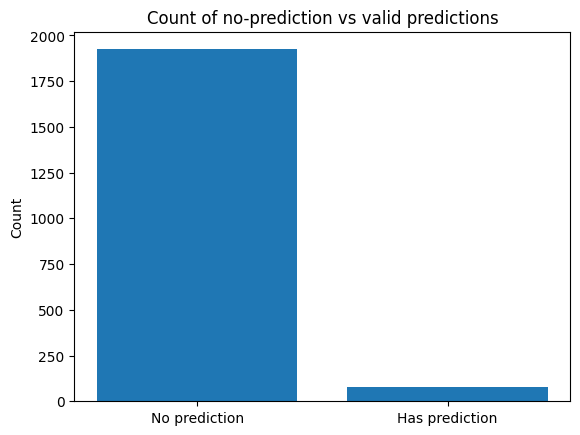

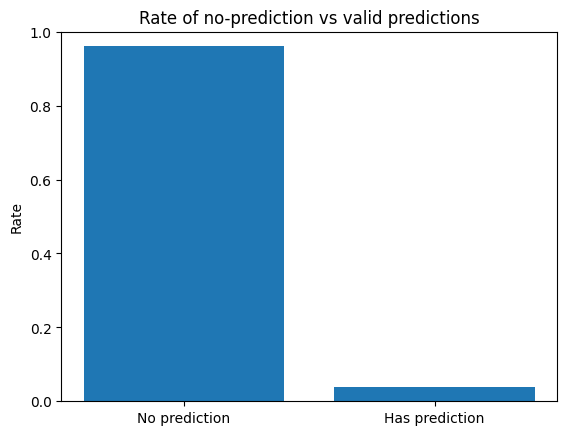

In [24]:
if total is not None and no_pred is not None:
    values = [no_pred, total - no_pred]
    labels = ['No prediction', 'Has prediction']
    plt.figure()
    plt.bar(labels, values)
    plt.title('Count of no-prediction vs valid predictions')
    plt.ylabel('Count')
    plt.show()

    rates = [no_pred_rate, valid_rate]
    plt.figure()
    plt.bar(labels, rates)
    plt.title('Rate of no-prediction vs valid predictions')
    plt.ylabel('Rate')
    plt.ylim(0, 1)
    plt.show()

## 5. Per-example outputs overview

In [25]:
if outputs_path.exists():
    with outputs_path.open('r') as f:
        outputs_json = json.load(f)

    # Some scripts pack metrics + outputs together
    outputs = outputs_json.get('outputs', outputs_json)

    df_outputs = pd.DataFrame(outputs)
    display(df_outputs.head())
else:
    df_outputs = pd.DataFrame()
    print('No outputs file found at', outputs_path)

,index,premise,hypothesis,true_label,pred_label,raw_output,valid_prediction
0,0,d8a causes am. d8a causes V9. d8a causes JGs4M...,['GfS'] is a valid minimal backdoor adjustment...,0,NaN,```\n```,False
1,1,mh5kM causes 5LXkE. mh5kM causes u5HG. mh5kM c...,['1EHw52'] is a valid minimal backdoor adjustm...,0,NaN,```\n```,False
2,2,s causes T. T causes NHElB. eMvKU causes v. eM...,['NHElB'] is a valid minimal backdoor adjustme...,0,NaN,```\n```,False
3,3,7 causes o. 7 causes hWNrFG. N causes hWNrFG. ...,['jP'] is a valid minimal backdoor adjustment ...,0,NaN,```\n```\n```\n```\n```\n```\n```\n```\n```\n`...,False
4,4,M causes TadeH. M causes AHw1v. M causes 6RKbY...,"['6RKbY', 'AHw1v', 'Ovj31L', 'TadeH'] is a val...",0,NaN,```\n```,False


### Valid vs invalid predictions (based on `valid_prediction`)

valid_prediction
False    1924
True       76
Name: count, dtype: int64


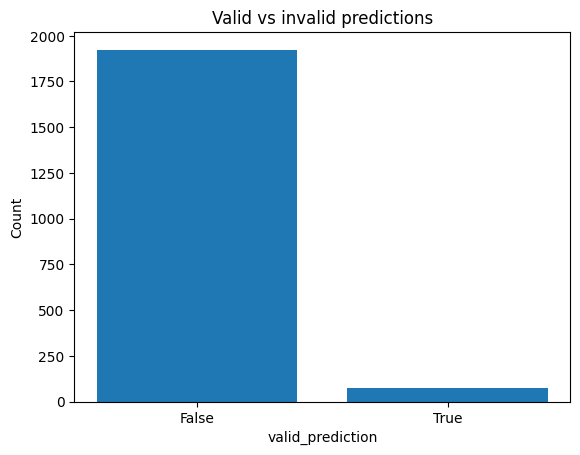

In [26]:
if not df_outputs.empty and 'valid_prediction' in df_outputs.columns:
    counts = df_outputs['valid_prediction'].value_counts(dropna=False)
    print(counts)
    plt.figure()
    plt.bar(counts.index.astype(str), counts.values)
    plt.title('Valid vs invalid predictions')
    plt.xlabel('valid_prediction')
    plt.ylabel('Count')
    plt.show()
else:
    print('`valid_prediction` column not found in outputs.')

### Sample error cases
You can inspect some of the misclassified or invalid predictions.

In [27]:
# Misclassified (where true_label != pred_label and pred_label is not null)
if not df_outputs.empty and 'true_label' in df_outputs.columns and 'pred_label' in df_outputs.columns:
    miscls = df_outputs[(df_outputs['pred_label'].notna()) & (df_outputs['true_label'] != df_outputs['pred_label'])]
    print('Number of misclassified examples:', len(miscls))
    display(miscls.head())
else:
    print('true_label / pred_label columns not found.')

# Invalid prediction samples
if not df_outputs.empty and 'valid_prediction' in df_outputs.columns:
    invalid_df = df_outputs[df_outputs['valid_prediction'] == False]
    print('Number of invalid predictions:', len(invalid_df))
    display(invalid_df.head())

Number of misclassified examples: 38


,index,premise,hypothesis,true_label,pred_label,raw_output,valid_prediction
37,37,ELM causes yQE0s. ELM causes Qu. YVKgYB causes...,['Qu'] is a valid minimal backdoor adjustment ...,0,1.0,: ['Qu'] is a valid minimal backdoor adjustmen...,True
43,43,9klz0Q causes d. 9klz0Q causes QCcYLZ. 6E8RAu ...,['d'] is a valid minimal backdoor adjustment s...,0,1.0,: ['d'] is a valid minimal backdoor adjustment...,True
111,111,UQddud causes 6ADrxZ. UQddud causes Nrp. 1kyD ...,"['Nrp', 'wTJLw'] is a valid minimal backdoor a...",0,1.0,```\nYes\n```\n```\nNo\n```\n```\nYes\n```\n``...,True
140,140,G causes I2inXq. G causes gOe55. G causes Yi8b...,"['FgG1LV', 'I2inXq', 'gOe55'] is a valid minim...",0,1.0,```\n<answer>Yes</answer>\n```\n```\n<answer>N...,True
188,188,uC causes cx. uC causes C7. uC causes 1Mm. uC ...,['1Mm'] is a valid minimal backdoor adjustment...,0,1.0,is a valid minimal backdoor adjustment set for...,True


Number of invalid predictions: 1924


,index,premise,hypothesis,true_label,pred_label,raw_output,valid_prediction
0,0,d8a causes am. d8a causes V9. d8a causes JGs4M...,['GfS'] is a valid minimal backdoor adjustment...,0,NaN,```\n```,False
1,1,mh5kM causes 5LXkE. mh5kM causes u5HG. mh5kM c...,['1EHw52'] is a valid minimal backdoor adjustm...,0,NaN,```\n```,False
2,2,s causes T. T causes NHElB. eMvKU causes v. eM...,['NHElB'] is a valid minimal backdoor adjustme...,0,NaN,```\n```,False
3,3,7 causes o. 7 causes hWNrFG. N causes hWNrFG. ...,['jP'] is a valid minimal backdoor adjustment ...,0,NaN,```\n```\n```\n```\n```\n```\n```\n```\n```\n`...,False
4,4,M causes TadeH. M causes AHw1v. M causes 6RKbY...,"['6RKbY', 'AHw1v', 'Ovj31L', 'TadeH'] is a val...",0,NaN,```\n```,False


## 6. (Optional) Load raw JSONL results

In [ ]:
if results_path.exists():
    df_jsonl = pd.read_json(results_path, lines=True)
    print('JSONL rows:', len(df_jsonl))
    display(df_jsonl.head())
else:
    print('JSONL file not found at', results_path)